<a href="https://colab.research.google.com/github/RosaliaGimenezBDS/M9_Reto_01/blob/main/Reto_1_M09_Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 1** - (Notebook 3/5)
Autores: **Meysam Madadi** & **Julio C. S. Jacques Junior**

---

# **Prerrequisitos**
- Consultar las instrucciones en los *Jupyter notebooks* anteriores.
- Ejecutar los *Jupyter notebooks* anteriores, en este caso:
 - *Jupyter notebook* 1.
 - *Jupyter notebook* 2.

# **Los objetivos de este Jupyter notebook**
- Practicar con **transfer learning** (aprendizaje por transferencia);
- Definir una **estrategia de entrenamiento**:
 - **Etapa 1:** Primero, entrenaremos nuestra "cabeza de regresión" (*regression head*). Para ello, "congelaremos" las capas de nuestro *backbone* (ResNet50) y entrenaremos solo las capas que hemos añadido al modelo. Esta etapa será más rápida que la siguiente, ya que solo se entrenan unas pocas capas.

 - **Etapa 2:** Luego, entrenaremos toda la red. Es decir, estableceremos todas las capas como "entrenables" para que los pesos de nuestro *backbone* también se puedan optimizar, junto con la "cabeza de regresión".
 - Finalmente, visualizamos la tendencia del entrenamiento de ambas etapas.
---

## Comprobando la versión de tensorflow


Otra posible solución parece ser seguir utilizando la versión 2.17.0 de tensorflow, haciendo el siguiente cambio en los códigos:

1. Al principio de cada Notebook, añadir el import de tf_keras:
import tensorflow as tf
import tf_keras

2. Luego, cada vez que encontréis "tf.keras", reemplazadlo por "tf_keras". Por ejemplo:

#model = tf.keras.models.load_model('/content/gdrive/MyDrive/M09-P01/init_model.h5')
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/init_model.h5')

In [2]:
# Este código fue probado en tensorflow 2.15.0 pero lo pasamos a 2.17 con algunos cambios en el código
#!pip install tensorflow==2.15.0
!pip install --upgrade tensorflow keras

import tensorflow as tf
import tf_keras

print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
2.17.0


# Montando nuestro Google Drive para guardar/cargar nuestros resultados

In [3]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/M09-P01/' as I
  # created a '/M09-P01/' folder in my google drive for this purpose.

Mounted at /content/gdrive


# Cargando el modelo y los datos preprocesados desde Drive

In [4]:
import numpy as np
import tensorflow as tf

with open('/content/gdrive/MyDrive/M09-P01/train.npy', 'rb') as f:
  X_train = np.load(f)
  Y_train = np.load(f)
  M_train = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/valid.npy', 'rb') as f:
  X_valid = np.load(f)
  Y_valid = np.load(f)
  M_valid = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/test.npy', 'rb') as f:
  X_test = np.load(f)
  Y_test = np.load(f)
  M_test = np.load(f)

model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/init_model.h5')

# **Entrenando el modelo mediante un ajuste fino de la red pre-entrenada**
- Esta es una forma muy estándar de **transferencia de aprendizaje** en la que el conocimiento se transfiere desde una red que, en general, se entrenó en un gran conjunto de datos hacia otro modelo con la misma o una arquitectura similar. En nuestro caso, la red (ResNet50) se ha entrenado en más de 3 millones de datos faciales para la tarea de reconocimiento facial. La transferencia de conocimiento se realiza inicializando los pesos de la nueva red a partir de la red preentrenada.
- Como hemos visto anteriormente, hemos creado nuestra propia "cabeza de regresión" mediante la adición de algunas capas a nuestro *backbone*. En esta arquitectura, los pesos de la "cabeza de regresión" se inicializan con valores aleatorios.
- Una buena práctica para entrenar esta red es primero congelar los pesos de las capas preentrenadas y optimizar los pesos de la "cabeza de regresión" (de la capas añadidas, inicializados con valores aleatorios). Luego, entrenar (y refinar) toda la red. Para implementar esta estrategia, realizamos el entrenamiento en dos etapas (**Etapa 1** y **Etapa 2**).


## **Etapa 1:** Entrenando la "cabeza de regresión"
- Primero, **congelamos las primeras N=174 capas** de nuestra red para permitir el ajuste fino de las últimas capas. Para esto, definimos si una capa es entrenable o no.
- Luego, entrenamos la "cabeza de regresión" con un procedimiento similar al "entrenamiento desde cero". Es decir, el entrenamiento será similar, pero **las capas que estén congeladas no tendrán sus pesos actualizados**.


In [5]:
import pickle
# freeze the first convolutional layers
counter = 0
for layer in model.layers:
  if counter <= 174:
    layer.trainable = False
  else:
    layer.trainable = True
  #print(counter, layer.name, layer.trainable)
  counter +=1

#### MODEL TRAINING ####
# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/M09-P01/best_model_st1.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=1e-4),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/gdrive/MyDrive/M09-P01/train_history_st1.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
94/94 [==============================] - ETA: 0s - loss: 0.2969 - mae: 0.3044

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 34s 252ms/step - loss: 0.2969 - mae: 0.3044 - val_loss: 0.2875 - val_mae: 0.2950
Epoch 2/50
94/94 [==============================] - 11s 118ms/step - loss: 0.2922 - mae: 0.3003 - val_loss: 0.2858 - val_mae: 0.2933
Epoch 3/50
94/94 [==============================] - 11s 118ms/step - loss: 0.2894 - mae: 0.2962 - val_loss: 0.2687 - val_mae: 0.2702
Epoch 4/50
94/94 [==============================] - 11s 120ms/step - loss: 0.2806 - mae: 0.2838 - val_loss: 0.2657 - val_mae: 0.2671
Epoch 5/50
94/94 [==============================] - 11s 121ms/step - loss: 0.2762 - mae: 0.2782 - val_loss: 0.2549 - val_mae: 0.2452
Epoch 6/50
94/94 [==============================] - 11s 120ms/step - loss: 0.2711 - mae: 0.2716 - val_loss: 0.2502 - val_mae: 0.2408
Epoch 7/50
94/94 [==============================] - 11s 119ms/step - loss: 0.2667 - mae: 0.2625 - val_loss: 0.2428 - val_mae: 0.2252
Epoch 8/50
94/94 [==============================] - 11s 121ms/step - loss: 0.259

## Evaluando el modelo entrenado (Etapa 1) en el conjunto de prueba

In [6]:
# loading the (best) saved model
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st1.h5')

# Evaluate the trained model on the test set
print('Evaluating on the test set')
predictions = model.predict(X_test, batch_size=32, verbose=1)

# Computing the Mean Absolute Error
# Also re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
mae = np.mean(abs(predictions[:,0] - Y_test)*100)

# Next we print the average error. Note that the error is rescaled back to the range [0-100]
print('\nThe final mean absolute error (on the Test set)  is ' + str(mae) + ' years old.')

Evaluating on the test set
32/32 [==============================] - 3s 80ms/step

The final mean absolute error (on the Test set)  is 4.931566164513617 years old.


## Imprimiendo algunas predicciones generadas (Etapa 1)

In [7]:
# printing some predictions and re-scaling the predicted values to the "age" range,
# using the normalization factor defined earlier, as output predictions are in
# the range of [0,1]
for i in range(0,10):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions[i]*100, Y_test[i]*100))

predicted age = 56.820 - Ground truth = 62.351
predicted age = 56.298 - Ground truth = 49.974
predicted age = 38.737 - Ground truth = 38.189
predicted age = 41.845 - Ground truth = 36.795
predicted age = 38.987 - Ground truth = 44.297
predicted age = 37.254 - Ground truth = 40.744
predicted age = 58.318 - Ground truth = 71.263
predicted age = 24.642 - Ground truth = 18.237
predicted age = 3.293 - Ground truth = 4.026
predicted age = 61.126 - Ground truth = 66.263


<ipython-input-7-d85e8ca77b4a>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions[i]*100, Y_test[i]*100))


## **Etapa 2:** ajuste fino de toda la red
- A continuación, cargaremos el modelo entrenado en la Etapa 1, **estableceremos todas sus capas como "entrenables"** y **entrenaremos todo el modelo**.
- La red se entrena con una estrategia similar a la anterior. Sin embargo, la **tasa de aprendizaje se reduce** (de "1e-4" a "1e-5") para permitir que el algoritmo de entrenamiento intente aproximar mejor el error mínimo deseado.


In [8]:
import pickle

# LOADING THE PREVIOUSLY TRAINED MODEL
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st1.h5')

# setting all layers of the model to trainable
model.trainable = True

#### MODEL TRAINING ####
# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/M09-P01/best_model_st2.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=1e-5),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/gdrive/MyDrive/M09-P01/train_history_st2.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
94/94 [==============================] - 65s 428ms/step - loss: 0.1818 - mae: 0.0498 - val_loss: 0.1814 - val_mae: 0.0552
Epoch 2/50
94/94 [==============================] - 44s 464ms/step - loss: 0.1779 - mae: 0.0409 - val_loss: 0.1761 - val_mae: 0.0363
Epoch 3/50
94/94 [==============================] - 53s 563ms/step - loss: 0.1747 - mae: 0.0367 - val_loss: 0.1732 - val_mae: 0.0362
Epoch 4/50
94/94 [==============================] - 51s 549ms/step - loss: 0.1718 - mae: 0.0363 - val_loss: 0.1704 - val_mae: 0.0360
Epoch 5/50
94/94 [==============================] - 55s 589ms/step - loss: 0.1686 - mae: 0.0351 - val_loss: 0.1677 - val_mae: 0.0395
Epoch 6/50
94/94 [==============================] - 55s 592ms/step - loss: 0.1655 - mae: 0.0341 - val_loss: 0.1643 - val_mae: 0.0358
Epoch 7/50
94/94 [==============================] - 49s 524ms/step - loss: 0.1623 - mae: 0.0316 - val_loss: 0.1613 - val_mae: 0.0358
Epoch 8/50
94/94 [==============================] - 44s 469ms/step - 

## Evaluando el modelo entrenado (Etapa 2) en el conjunto de prueba

In [9]:
# loading the (best) saved model
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st2.h5')

# Evaluate the trained model on the test set
print('Evaluating on the test set')
predictions = model.predict(X_test, batch_size=32, verbose=1)

# Computing the Mean Absolute Error
# Also re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
mae = np.mean(abs(predictions[:,0] - Y_test)*100)

# Next we print the average error. Note that the error is rescaled back to the range [0-100]
print('\nThe final mean absolute error (on the Test set)  is ' + str(mae) + ' years old.')

Evaluating on the test set
32/32 [==============================] - 3s 80ms/step

The final mean absolute error (on the Test set)  is 4.23920901094297 years old.


# Visualizando el historial de entrenamiento de ambas etapas (Etapa 1 y Etapa 2)
- Las curvas de ambas etapas están concatenadas.
- Se puede observar una caída de la función de pérdida (*Loss*) cerca del *epoch* 50, lo cual indica el final de la Etapa 1 de entrenamiento y el inicio de la Etapa 2.
- Tambien se puede observar como la Etapa 2 mejora el desempeño en comparación con la Etapa 1 y con respecto al error evaluado en el conjunto de validación.

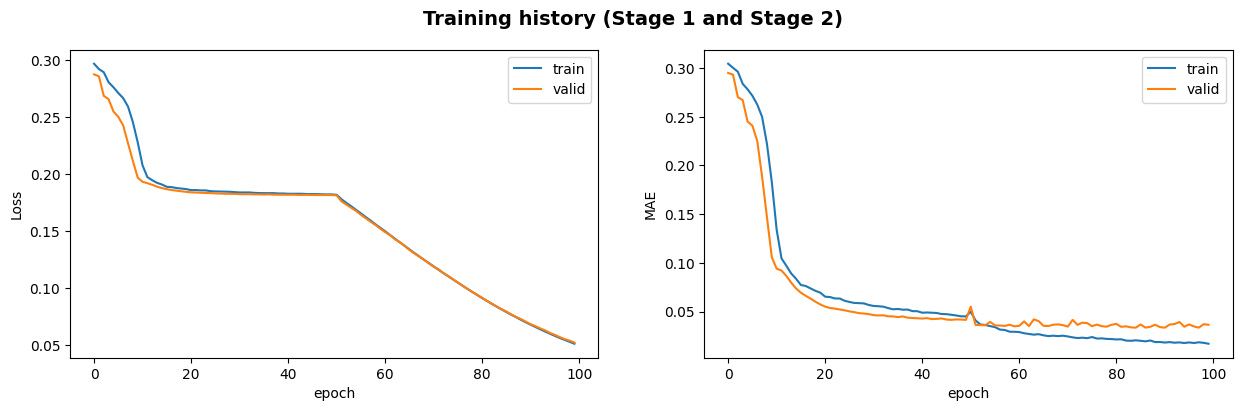

In [10]:
import pickle
from matplotlib import pyplot as plt

train_hist = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_st1.pkl',"rb"))
train_hist2 = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_st2.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist2['loss'])
ax1.plot(train_hist['val_loss']+train_hist2['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist2['mae'])
ax2.plot(train_hist['val_mae']+train_hist2['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')